# Evaluation Tessa

In this notebook, we calculate the performance of Tessa on our datasets. Please run the script tessa_wraper for each dataset before running this notebook.

In [1]:
import os
import pandas as pd
import numpy as np

os.environ['R_HOME'] = 'C:/Users/felix.drost/Anaconda3/envs/tessa/Lib/R' 
import rpy2.robjects as rob

In [2]:
import sys
sys.path.append('../../tcr_embedding/evaluation')

from Metrics import get_knn_classification, get_normalized_mutual_information
from Metrics import get_silhouette_scores

## Functions for Tessa embedding

In [3]:
def get_tessa_weights(base_dir):
    """
    Load the b-values from the result RData
    :param base_dir: path to the base folder of the experiment
    :return: numpy array [3] giving the b-weights
    """
    rob.r['load'](f'{base_dir}/res/tessa_final.RData')
    b = rob.r['tessa_results'][0]
    b = np.array(b)
    return b


def get_tessa_unweighted_distances(base_dir):
    """
    Extract the Briseis encoding from file
    :param file_dir: path to the base folder of the experiment
    :return: numpy array [num_cells, 30] giving the embedding space by Briseis
    """
    unweighted_dist = pd.read_csv(f'{base_dir}/tessa_tcr_embedding.csv', index_col=0)
    unweighted_dist = unweighted_dist.values
    return unweighted_dist


def get_weighted_distances(unweighted_dist, b):
    """
    Calculates the weigthed distance
    :param unweighted_dist: numpy array [num_cells, 30] giving the TCR embedding
    :param b: numpy array [30] giving the position weights
    :return: numpy array [num_cells, 30] giving the weighted embedding
    """
    weighted_dist = unweighted_dist * b
    return weighted_dist

def calculate_embedding(dataset, split, donor=None, do_atlas=True, do_weighting=True):
    suffix = 'atlas' 
    if not do_atlas:
        suffix = 'query'
    base_dir = f'results/tessa/output/{dataset}/'
    if donor is not None:
        base_dir += f'{donor}/'
    base_dir += f'{split}'    
    embedding = get_tessa_unweighted_distances(f'{base_dir}/{suffix}')

    if do_weighting:
        b = get_tessa_weights(f'{base_dir}/atlas')
        embedding = get_weighted_distances(embedding, b)
    return embedding

## Helper Functions

In [4]:
def get_labels(split, donor, return_df=False, col='binding_name'):
    """
    Extract the labels from the TCR file
    :param donor: id of the 10x donor
    :return: list [num_cells], list [num_cells] representing the binding labels for atlas and query set
    """
    path_labels = f'../../data/tessa/10x/{donor}/{split}_'
    df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
    df_query = pd.read_csv(path_labels+'tcrs_query.csv')
    if not return_df:
        return df_atlas[col].tolist(), df_query[col].tolist()
    df_atlas = df_atlas[['contig_id', col]]
    df_query = df_query[['contig_id', col]]
    
    df_atlas = df_atlas.set_index('contig_id')
    df_atlas.index.name = None
    df_query = df_query.set_index('contig_id')
    df_query.index.name = None
    return df_atlas, df_query

In [5]:
def get_tessa_clusters(split, donor):
    path_file = 'results/tessa/output/'
    if donor == 'covid':
        path_file += 'covid/'
    else:
        path_file += f'10x/{donor}/'
    path_file += f'{split}/atlas/res/tessa_final.RData'
    rob.r['load'](path_file)
    clusters = rob.r['tessa_results'][1]

    barcodes = list(clusters[0])
    group_IDs = list(clusters[1])
    cluster_numbers = list(clusters[2])
    df_clusters = pd.DataFrame({'barcode': barcodes, 'group_ID': group_IDs, 'cluster_number': cluster_numbers})
  
    df_clusters['barcode'] = [name.replace('.', '-') for name in df_clusters['barcode']]
    df_clusters = df_clusters.set_index('barcode')
    df_clusters.index.name = None
    df_clusters.columns = ['group', 'cluster']
    return df_clusters

## 10x - Donor 1

In [6]:
path_labels = f'../../data/tessa/10x/donor_1/split_2_'
df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
df_query = pd.read_csv(path_labels+'tcrs_query.csv')


In [7]:
dataset = '10x'
donor = 'donor_1'

model_names = []
splits = []
metrics = []
scores = []

for i in range(5):
    split = f'split_{i}'
    print(split)
    
    # KNN Evaluation
    embedding_atlas = calculate_embedding(dataset, split, donor, do_atlas=True, do_weighting=True)
    embedding_query = calculate_embedding(dataset, split, donor, do_atlas=False, do_weighting=True)
    
    labels_atlas, labels_query = get_labels(split, donor)
    
    score = get_knn_classification(embedding_atlas, embedding_query, labels_atlas, labels_query)
    score = score['weighted avg']['f1-score']
    
    model_names.append('tessa')
    splits.append(i)
    metrics.append(f'Prediction test')
    scores.append(score)
    
    # Clustering Evaluation
    labels_atlas, _ = get_labels(split, donor, return_df=True)
    labels_predicted = get_tessa_clusters(split, donor)
    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    score = get_normalized_mutual_information(df_full['binding_name'], df_full['cluster'])
    
    model_names.append('tessa')
    splits.append(i)
    metrics.append(f'NMI')
    scores.append(score)
    
    
results_10x_tessa_d1 = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results_10x_tessa_d1 = pd.DataFrame(results_10x_tessa_d1)
results_10x_tessa_d1.to_csv('results/performance_tessa_10x_donor_1.csv')
results_10x_tessa_d1

split_0


C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


split_1


C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


split_2


C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


split_3


C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


split_4


C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,split,metrics,scores
0,tessa,0,Prediction test,0.680014
1,tessa,0,NMI,0.489977
2,tessa,1,Prediction test,0.807037
3,tessa,1,NMI,0.512067
4,tessa,2,Prediction test,0.611352
5,tessa,2,NMI,0.535020
6,tessa,3,Prediction test,0.748408
7,tessa,3,NMI,0.550911
8,tessa,4,Prediction test,0.212566
9,tessa,4,NMI,0.449310


## 10x - Donor 2

In [8]:
dataset = '10x'
donor = 'donor_2'

model_names = []
splits = []
metrics = []
scores = []

for i in range(5):
    split = f'split_{i}'
    
    # KNN Evaluation
    embedding_atlas = calculate_embedding(dataset, split, donor, do_atlas=True, do_weighting=True)
    embedding_query = calculate_embedding(dataset, split, donor, do_atlas=False, do_weighting=True)
    
    labels_atlas, labels_query = get_labels(split, donor)
    score = get_knn_classification(embedding_atlas, embedding_query, labels_atlas, labels_query)
    score = score['weighted avg']['f1-score']
    
    model_names.append('tessa')
    splits.append(i)
    metrics.append(f'Prediction test')
    scores.append(score)
    
    # Clustering Evaluation
    labels_atlas, _ = get_labels(split, donor, return_df=True)
    labels_predicted = get_tessa_clusters(split, donor)
    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    score = get_normalized_mutual_information(df_full['binding_name'], df_full['cluster'])
    
    model_names.append('tessa')
    splits.append(i)
    metrics.append(f'NMI')
    scores.append(score)
    
results_10x_tessa_d2 = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results_10x_tessa_d2 = pd.DataFrame(results_10x_tessa_d2)
results_10x_tessa_d2.to_csv('results/performance_tessa_10x_donor_2.csv')
results_10x_tessa_d2

C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\tessa_2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

,model,split,metrics,scores
0,tessa,0,Prediction test,0.815956
1,tessa,0,NMI,0.347003
2,tessa,1,Prediction test,0.624713
3,tessa,1,NMI,0.385786
4,tessa,2,Prediction test,0.602985
5,tessa,2,NMI,0.372139
6,tessa,3,Prediction test,0.691987
7,tessa,3,NMI,0.387633
8,tessa,4,Prediction test,0.492329
9,tessa,4,NMI,0.421416


## Covid Dataset

In [9]:
def get_labels_covid(split, return_df=False, col='T_cells'):
    path_labels = f'../../data/tessa/covid/{split}_'
    df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
    if not return_df:
        return df_atlas[col].tolist()
    df_atlas = df_atlas[['contig_id', col]]
    
    df_atlas = df_atlas.set_index('contig_id')
    df_atlas.index.name = None
    return df_atlas

In [10]:
dataset = 'covid'

model_names = []
splits = []
metrics = []
scores = []

for i in range(5):
    split = f'split_{i}'
    
    # Celltype
    labels_atlas = get_labels_covid(split, return_df=True, col='T_cells')
    labels_predicted = get_tessa_clusters(split, 'covid')
    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    score = get_normalized_mutual_information(df_full['T_cells'], df_full['cluster'])
    
    model_names.append('tessa')
    splits.append(i)
    metrics.append(f'NMI_cell_type')
    scores.append(score)
    
    # Reactivity
    labels_atlas = get_labels_covid(split, return_df=True, col='reactivity')
    labels_predicted = get_tessa_clusters(split, 'covid')
    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    score = get_normalized_mutual_information(df_full['reactivity'], df_full['cluster'])
    
    model_names.append('tessa')
    splits.append(i)
    metrics.append(f'NMI_reactivity')
    scores.append(score)
    
results_covid_tessa = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results_covid_tessa = pd.DataFrame(results_covid_tessa)
results_covid_tessa.to_csv('results/performance_tessa_covid.csv')
results_covid_tessa

,model,split,metrics,scores
0,tessa,0,NMI_cell_type,0.154338
1,tessa,0,NMI_reactivity,0.074758
2,tessa,1,NMI_cell_type,0.141279
3,tessa,1,NMI_reactivity,0.083730
4,tessa,2,NMI_cell_type,0.145306
5,tessa,2,NMI_reactivity,0.065588
6,tessa,3,NMI_cell_type,0.149500
7,tessa,3,NMI_reactivity,0.060792
8,tessa,4,NMI_cell_type,0.144616
9,tessa,4,NMI_reactivity,0.079768


## UMAP

In [11]:
import scanpy as sc
import anndata as ad
sys.path.append('../../config')
from constants_10x import ANTIGEN_COLORS
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

split_0


... storing 'binding' as categorical


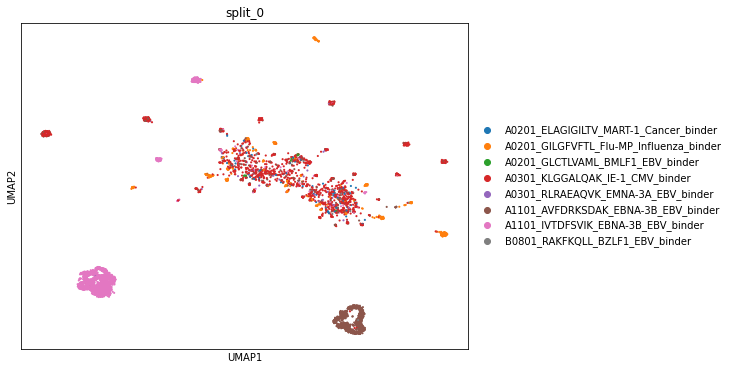

split_1


... storing 'binding' as categorical


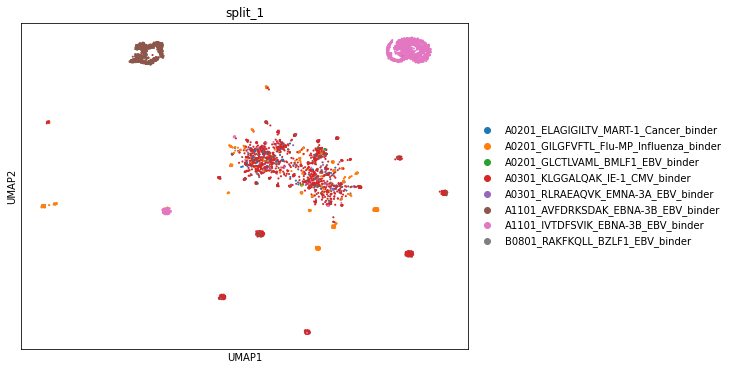

split_2


... storing 'binding' as categorical


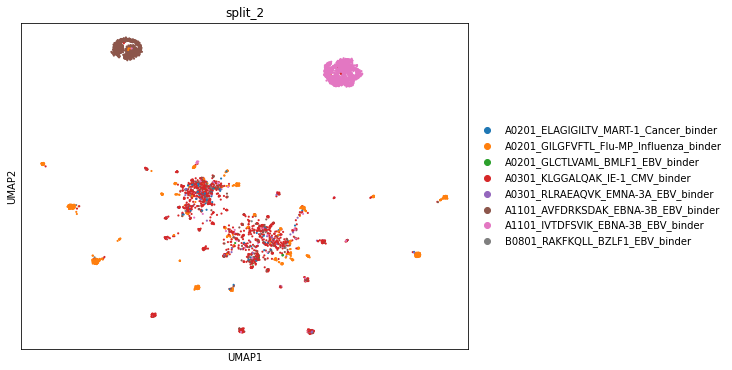

split_3


... storing 'binding' as categorical


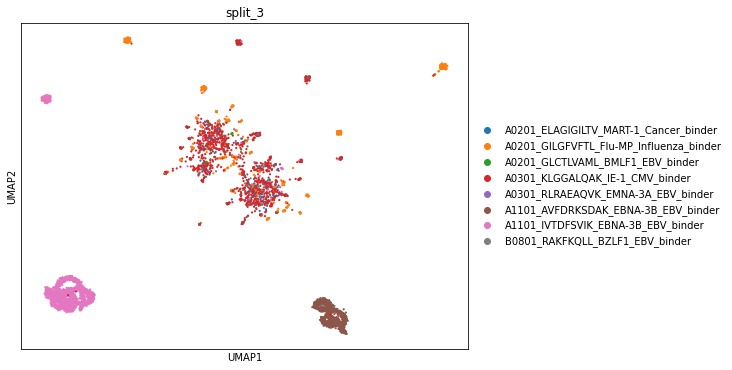

split_4


... storing 'binding' as categorical


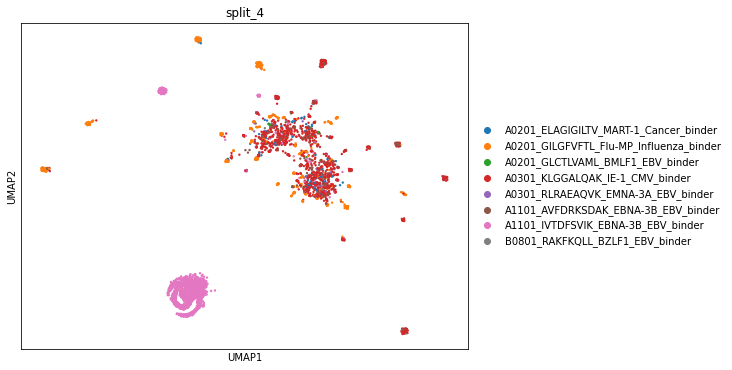

In [12]:
dataset = '10x'
donor = 'donor_1'

model_names = []
splits = []
metrics = []
scores = []

for i in range(5):
    split = f'split_{i}'
    print(split)
    
    # KNN Evaluation
    embedding = calculate_embedding(dataset, split, donor, do_atlas=True, do_weighting=True)    
    labels, _ = get_labels(split, donor)
    
    adata_tmp = ad.AnnData(embedding, obs={'binding': labels})
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    sc.pl.umap(adata_tmp, color='binding', title=split)

split_0


... storing 'binding' as categorical


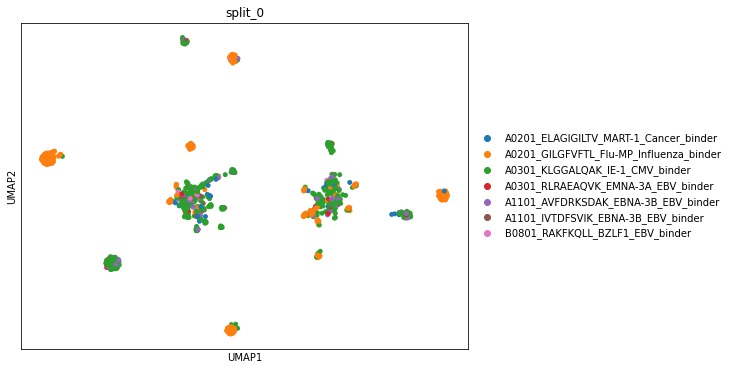

split_1


... storing 'binding' as categorical


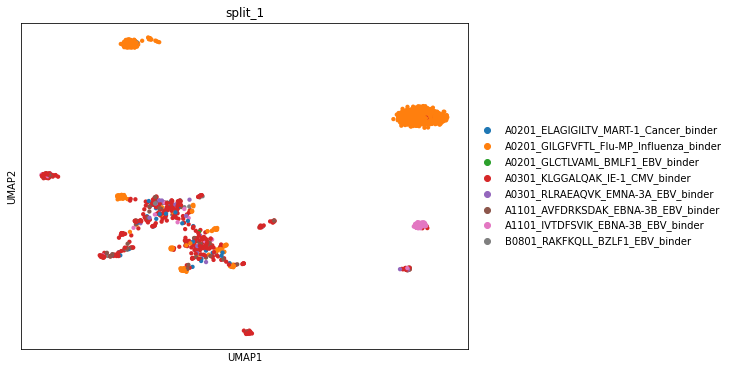

split_2


... storing 'binding' as categorical


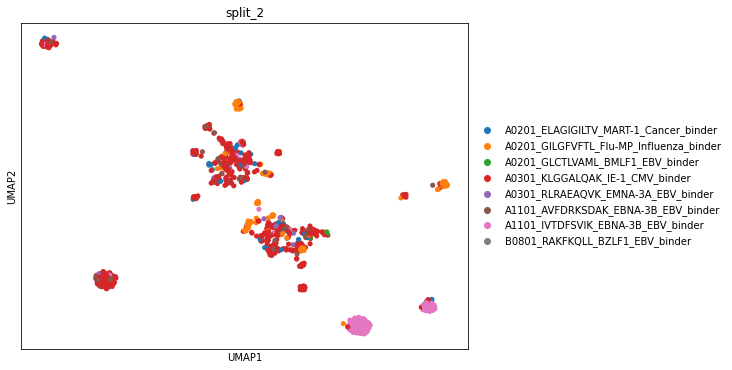

split_3


... storing 'binding' as categorical


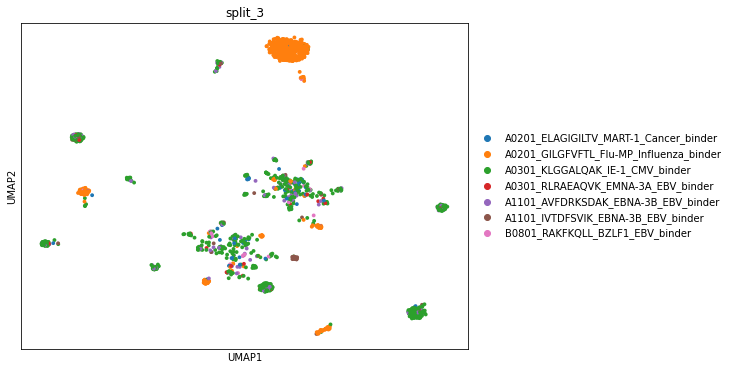

split_4


... storing 'binding' as categorical


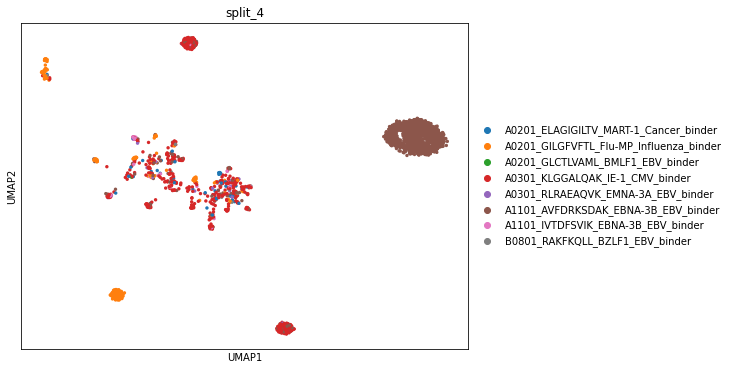

In [13]:
dataset = '10x'
donor = 'donor_1'

model_names = []
splits = []
metrics = []
scores = []

for i in range(5):
    split = f'split_{i}'
    print(split)
    
    # KNN Evaluation
    embedding = calculate_embedding(dataset, split, donor, do_atlas=False, do_weighting=True)    
    _, labels = get_labels(split, donor)
    
    adata_tmp = ad.AnnData(embedding, obs={'binding': labels})
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    sc.pl.umap(adata_tmp, color='binding', title=split)

split_0


... storing 'binding' as categorical
... storing 'set' as categorical


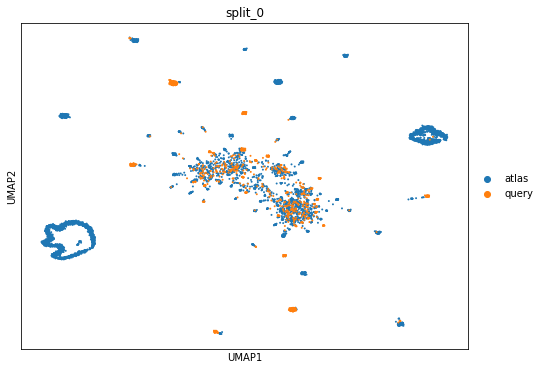

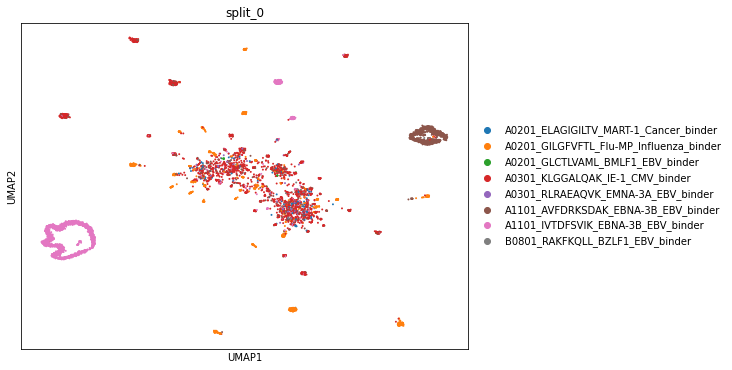

split_1


... storing 'binding' as categorical
... storing 'set' as categorical


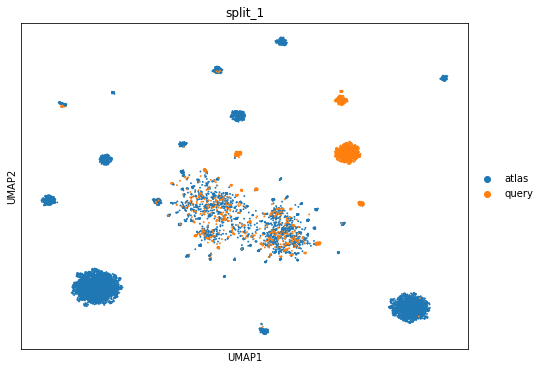

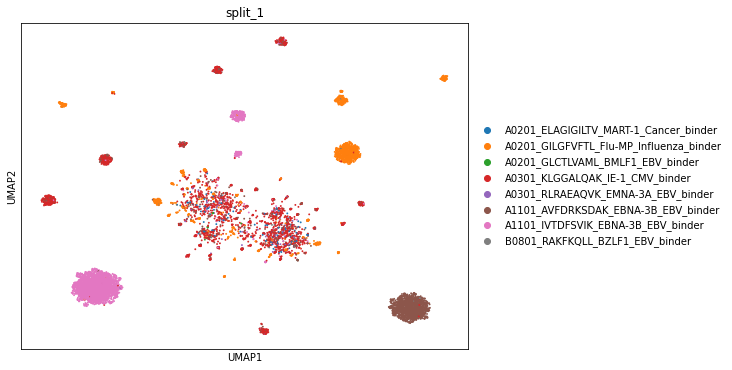

split_2


... storing 'binding' as categorical
... storing 'set' as categorical


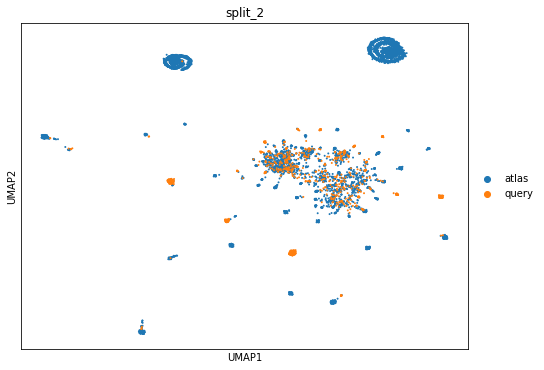

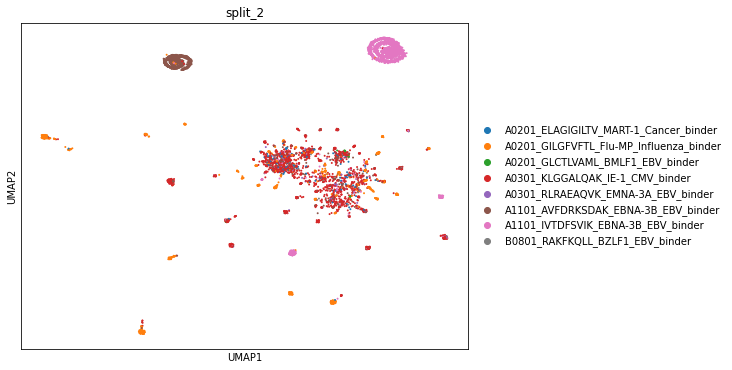

split_3


... storing 'binding' as categorical
... storing 'set' as categorical


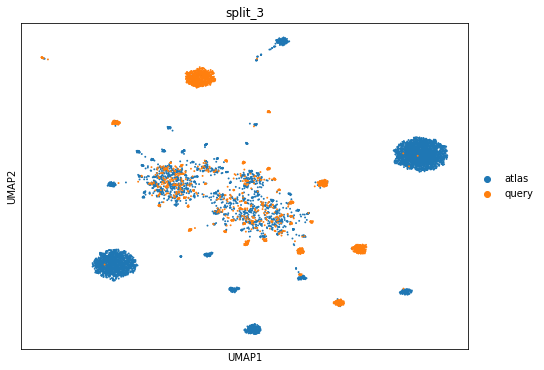

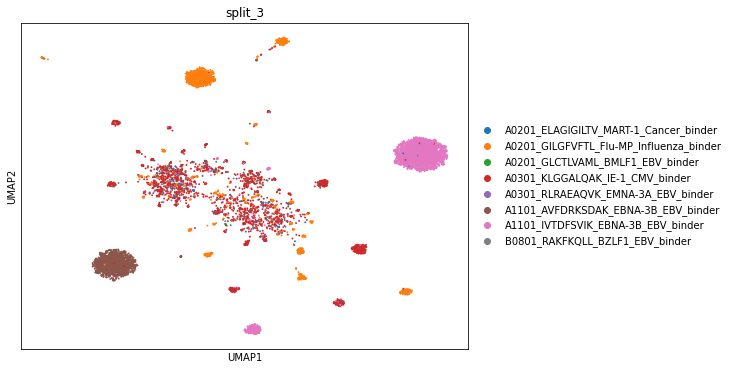

split_4


... storing 'binding' as categorical
... storing 'set' as categorical


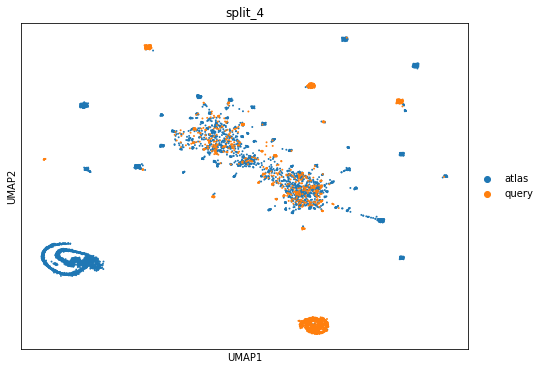

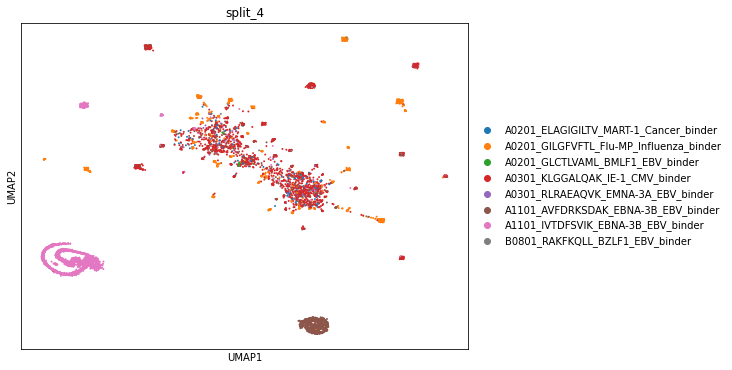

In [14]:
dataset = '10x'
donor = 'donor_1'

model_names = []
splits = []
metrics = []
scores = []

for i in range(5):
    split = f'split_{i}'
    print(split)
    
    # KNN Evaluation
    embedding_atlas = calculate_embedding(dataset, split, donor, do_atlas=True, do_weighting=True) 
    embedding_query = calculate_embedding(dataset, split, donor, do_atlas=False, do_weighting=True)    
    labels_atlas, labels_query = get_labels(split, donor)
    
    embedding = np.concatenate([embedding_atlas, embedding_query])
    adata_tmp = ad.AnnData(embedding, obs={'binding': labels_atlas+labels_query, 
                                           'set': ['atlas']*len(labels_atlas) + ['query']*len(labels_query)})
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    sc.pl.umap(adata_tmp, color='set', title=split)
    sc.pl.umap(adata_tmp, color='binding', title=split)
    